In [2]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import wget
from conlleval import evaluate

### Preprocessing Steps Applied

In [3]:
def preprocess_data(data: list) -> list:
    sentences = []
    for sentence_data in data:
        sentence_id = sentence_data["sentence_id"]
        sentence = sentence_data["sentence"]
        tokens = sentence.split()

        aspect_terms = [term["term"] for term in sentence_data["aspect_terms"]]
        # initilize the labels
        labels = ["O" for _ in range(len(tokens))]

        len_prefix = []
        new_token = True
        for i in range(len(sentence)):
            if sentence[i] == " ":
                new_token = True
            elif new_token:
                len_prefix.append(i)
                new_token = False

        for term in sentence_data["aspect_terms"]:
            term_start = int(term["from"])
            term_end = int(term["to"])

            # Binary search to find the token index of the term
            low = 0
            high = len(len_prefix)
            while low < high:
                mid = (low + high) // 2
                if len_prefix[mid] < term_start:
                    low = mid + 1
                else:
                    high = mid

            token_idx = low

            if token_idx == len(len_prefix):
                token_idx -= 1

            # encoding the aspect term
            for i, cur_term_token in enumerate(term["term"].split()):
                while cur_term_token not in tokens[token_idx]:
                    token_idx -= 1
                if i == 0:
                    labels[token_idx] = "B"
                else:
                    try:
                        labels[token_idx] = "I"
                    except:
                        print(sentence)
                        print(len_prefix[token_idx-1])
                        raise Exception("Index out of range")

                token_idx += 1

        sentences.append({
            "sentence": sentence,
            "tokens": tokens,
            "labels": labels,
            "aspect_terms": aspect_terms
        })

    return sentences

In [4]:
with open("train.json") as f:
    train_data = json.load(f)

with open("val.json") as f:
    val_data = json.load(f)

val_data = preprocess_data(val_data)
train_data = preprocess_data(train_data)

with open("train_task_1.json", "w") as f:
    json.dump(train_data, f, indent=4)

with open("val_task_1.json", "w") as f:
    json.dump(val_data, f, indent=4)

### Model Training

In [4]:
# download the fasttext word embeddings
url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip"
wget.download(url)

'wiki-news-300d-1M-subword.vec.zip'

In [5]:
!unzip wiki-news-300d-1M-subword.vec.zip

Archive:  wiki-news-300d-1M-subword.vec.zip
  inflating: wiki-news-300d-1M-subword.vec  


In [4]:
def load_vectors(fname, limit=5000000):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    counter = 0
    for line in fin:
        counter += 1
        if counter > limit:
            break
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

In [5]:
fastText_vec = load_vectors("wiki-news-300d-1M-subword.vec")

In [ ]:
# download the glove word embeddings
url = "http://nlp.stanford.edu/data/glove.6B.zip"
wget.download(url)

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [7]:
def load_glove_vectors(fname, limit=5000000):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    data = {}
    counter = 0
    for line in fin:
        counter += 1
        if counter > limit:
            break
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data


In [8]:
glove_vec = load_glove_vectors("glove.6B.300d.txt")

In [10]:
class TextDataset(Dataset):
    def __init__(self, sentences: list, vec: dict):
        self.data = sentences
        self.vec = vec

    def get_embedding(self, word: str, vec: dict) -> list:
        vecs = []
        start = 0
        end = len(word)
        while start != len(word):
            if word[start:end] in vec:
                vecs.append(vec[word[start:end]])
                start = end
                end = len(word)
            else:
                if end == 1:
                    print("COULD NOT FIND WORD", word)
                    break
                end -= 1

        return np.mean(vecs, axis=0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int) -> dict:
        sentence = self.data[idx]

        tokens = sentence["tokens"]
        bio_labels = sentence["labels"]

        embeddings = [self.get_embedding(token.lower(), self.vec) for token in tokens]
        embeddings = np.array(embeddings, dtype=np.float32)

        labels = []
        for label in bio_labels:
            if label == "B":
                labels.append(1)
            elif label == "I":
                labels.append(2)
            else:
                labels.append(0)

        labels = np.array(labels, dtype=np.longlong)

        return {
            "embeddings": torch.from_numpy(embeddings), 
            "labels": torch.from_numpy(labels)
        }

In [11]:
def embedding_colate_fn(batch):
    embeddings = [item["embeddings"] for item in batch]
    labels = [item["labels"] for item in batch]

    embeddings_padded = torch.nn.utils.rnn.pad_sequence(embeddings, batch_first=True)
    labels_padded = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)

    return embeddings_padded, labels_padded

train_fastText_dataset = TextDataset(train_data, fastText_vec)
val_fastText_dataset = TextDataset(val_data, fastText_vec)

train_fastText_loader = DataLoader(train_fastText_dataset, batch_size=32, shuffle=True, collate_fn=embedding_colate_fn)
val_fastText_loader = DataLoader(val_fastText_dataset, batch_size=32, shuffle=False, collate_fn=embedding_colate_fn)

train_glove_dataset = TextDataset(train_data, glove_vec)
val_glove_dataset = TextDataset(val_data, glove_vec)

train_glove_loader = DataLoader(train_glove_dataset, batch_size=32, shuffle=True, collate_fn=embedding_colate_fn)
val_glove_loader = DataLoader(val_glove_dataset, batch_size=32, shuffle=False, collate_fn=embedding_colate_fn)

In [12]:
def numeric_to_tag(num):
    mapping = {0: "O", 1: "B", 2: "I"}
    return mapping.get(num, "O")

def get_f1_scores(model, loader, device='cuda'):
    device = torch.device(device)
    model.to(device)
    model.eval()

    lines = []
    with torch.no_grad():
        for embeddings, labels in loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)
            outputs = model(embeddings)
            predictions = torch.argmax(outputs, dim=-1)
            
            for i in range(len(predictions)):
                true_seq = labels[i].cpu().numpy().tolist()
                pred_seq = predictions[i].cpu().numpy().tolist()

                filtered_true = [numeric_to_tag(num) for num in true_seq if num != -100]
                filtered_pred = [numeric_to_tag(num) for num in pred_seq if num != -100]

                for j in range(len(filtered_true)):
                    # add lines in the format of " true_label predicted_label"
                    lines.append(f" {filtered_true[j]} {filtered_pred[j]}")

                # separate lines using the given format
                lines.append("-X-  ")

    evaluated = evaluate(lines, delimiter=' ')
    return evaluated["overall"]["chunks"]["evals"]["f1"], evaluated["overall"]["tags"]["evals"]["f1"]

In [15]:
# RNN model
class RNNTagger(nn.Module):
    def __init__(self, input_dim=300, hidden_dim=128, output_dim=3):
        super(RNNTagger, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

# GRU model
class GRUTagger(nn.Module):
    def __init__(self, input_dim=300, hidden_dim=128, output_dim=3):
        super(GRUTagger, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out)
        return out

# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-2, device='cuda', model_name="rnn_glove"):
    device = torch.device(device)
    model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=-100)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_f1 = 0.0
    
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for embeddings, labels in train_loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * embeddings.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for embeddings, labels in val_loader:
                embeddings = embeddings.to(device)
                labels = labels.to(device)
                outputs = model(embeddings)
                loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
                val_running_loss += loss.item() * embeddings.size(0)
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_f1_chunk, val_f1_tag = get_f1_scores(model, val_loader, device)
        f1_f1_score_val = 2 * val_f1_chunk * val_f1_tag / (val_f1_chunk + val_f1_tag)

        if f1_f1_score_val > best_f1:
            best_f1 = f1_f1_score_val
            torch.save(model.state_dict(), f"{model_name}.pt")

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Val Loss: {val_epoch_loss:.4f} - Val F1: {f1_f1_score_val:.4f}")
        
    return train_losses, val_losses

### Model 1 - RNN with FastText embeddings

Epoch 1/10 - Train Loss: 0.3598 - Val Loss: 0.1869 - Val F1: 0.6648
Epoch 2/10 - Train Loss: 0.2160 - Val Loss: 0.1651 - Val F1: 0.7665
Epoch 3/10 - Train Loss: 0.1790 - Val Loss: 0.2468 - Val F1: 0.7254
Epoch 4/10 - Train Loss: 0.1721 - Val Loss: 0.1436 - Val F1: 0.7762
Epoch 5/10 - Train Loss: 0.1687 - Val Loss: 0.1419 - Val F1: 0.7854
Epoch 6/10 - Train Loss: 0.1648 - Val Loss: 0.1304 - Val F1: 0.8010
Epoch 7/10 - Train Loss: 0.1538 - Val Loss: 0.1441 - Val F1: 0.7644
Epoch 8/10 - Train Loss: 0.1517 - Val Loss: 0.1519 - Val F1: 0.7592
Epoch 9/10 - Train Loss: 0.1449 - Val Loss: 0.1317 - Val F1: 0.7922
Epoch 10/10 - Train Loss: 0.1406 - Val Loss: 0.1335 - Val F1: 0.8225


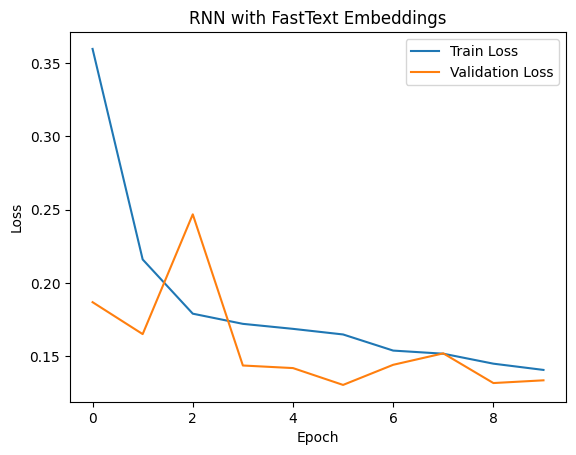

In [16]:
# Model 1 - RNN with FastText embeddings
model_rnn_fastText = RNNTagger()
train_losses_rnn_fastText, val_losses_rnn_fastText = train_model(model_rnn_fastText, train_fastText_loader, val_fastText_loader, num_epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu', model_name="rnn_fastText")

# Plot loss curves
plt.figure()
plt.plot(train_losses_rnn_fastText, label='Train Loss')
plt.plot(val_losses_rnn_fastText, label='Validation Loss')
plt.title('RNN with FastText Embeddings')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('rnn_fastText_loss.png')
plt.show()

### Model 2 - RNN with GloVe embeddings

Epoch 1/10 - Train Loss: 0.2288 - Val Loss: 0.1455 - Val F1: 0.7789
Epoch 2/10 - Train Loss: 0.1606 - Val Loss: 0.1283 - Val F1: 0.8055
Epoch 3/10 - Train Loss: 0.1328 - Val Loss: 0.1379 - Val F1: 0.7996
Epoch 4/10 - Train Loss: 0.1176 - Val Loss: 0.1507 - Val F1: 0.7843
Epoch 5/10 - Train Loss: 0.1059 - Val Loss: 0.1243 - Val F1: 0.8313
Epoch 6/10 - Train Loss: 0.0917 - Val Loss: 0.1281 - Val F1: 0.8186
Epoch 7/10 - Train Loss: 0.0931 - Val Loss: 0.1346 - Val F1: 0.8232
Epoch 8/10 - Train Loss: 0.0729 - Val Loss: 0.1423 - Val F1: 0.8254
Epoch 9/10 - Train Loss: 0.0679 - Val Loss: 0.1360 - Val F1: 0.8368
Epoch 10/10 - Train Loss: 0.0575 - Val Loss: 0.1516 - Val F1: 0.8130


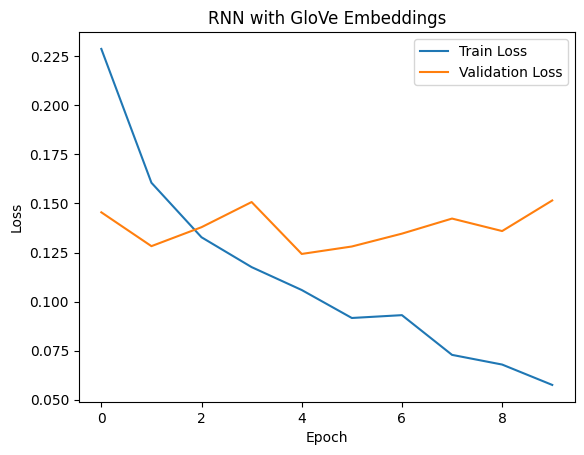

In [17]:
# Model 2 - RNN with GloVe embeddings
model_rnn_glove = RNNTagger()
train_losses_rnn_glove, val_losses_rnn_glove = train_model(model_rnn_glove, train_glove_loader, val_glove_loader, num_epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu', model_name="rnn_glove")

# Plot loss curves
plt.figure()
plt.plot(train_losses_rnn_glove, label='Train Loss')
plt.plot(val_losses_rnn_glove, label='Validation Loss')
plt.title('RNN with GloVe Embeddings')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('rnn_glove_loss.png')
plt.show()

### Model 3 - GRU with FastText embeddings

Epoch 1/10 - Train Loss: 0.2601 - Val Loss: 0.1393 - Val F1: 0.7879
Epoch 2/10 - Train Loss: 0.1549 - Val Loss: 0.1334 - Val F1: 0.8071
Epoch 3/10 - Train Loss: 0.1363 - Val Loss: 0.1177 - Val F1: 0.8236
Epoch 4/10 - Train Loss: 0.1232 - Val Loss: 0.1254 - Val F1: 0.8058
Epoch 5/10 - Train Loss: 0.1174 - Val Loss: 0.1174 - Val F1: 0.8279
Epoch 6/10 - Train Loss: 0.1047 - Val Loss: 0.1145 - Val F1: 0.8257
Epoch 7/10 - Train Loss: 0.0946 - Val Loss: 0.1191 - Val F1: 0.8433
Epoch 8/10 - Train Loss: 0.0901 - Val Loss: 0.1156 - Val F1: 0.8372
Epoch 9/10 - Train Loss: 0.0772 - Val Loss: 0.1248 - Val F1: 0.8444
Epoch 10/10 - Train Loss: 0.0656 - Val Loss: 0.1248 - Val F1: 0.8266


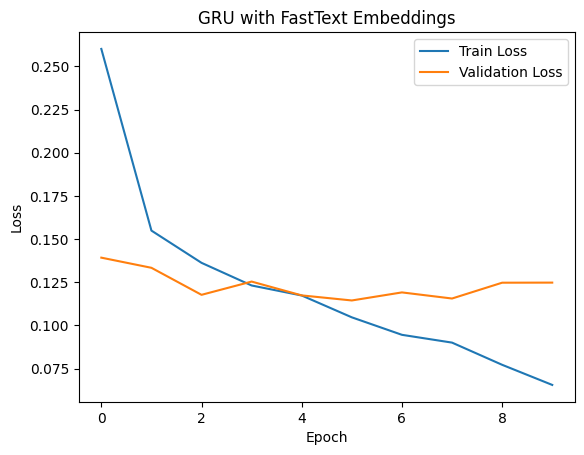

In [18]:
# Model 3 - GRU with FastText embeddings
model_gru_fastText = GRUTagger()
train_losses_gru_fastText, val_losses_gru_fastText = train_model(model_gru_fastText, train_fastText_loader, val_fastText_loader, num_epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu', model_name="gru_fastText")

# Plot loss curves
plt.figure()
plt.plot(train_losses_gru_fastText, label='Train Loss')
plt.plot(val_losses_gru_fastText, label='Validation Loss')
plt.title('GRU with FastText Embeddings')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('gru_fastText_loss.png')
plt.show()

### Model 4 - GRU with GloVe embeddings

Epoch 1/10 - Train Loss: 0.2257 - Val Loss: 0.1395 - Val F1: 0.8136
Epoch 2/10 - Train Loss: 0.1334 - Val Loss: 0.1158 - Val F1: 0.8420
Epoch 3/10 - Train Loss: 0.1040 - Val Loss: 0.1122 - Val F1: 0.8352
Epoch 4/10 - Train Loss: 0.0801 - Val Loss: 0.1316 - Val F1: 0.8219
Epoch 5/10 - Train Loss: 0.0615 - Val Loss: 0.1295 - Val F1: 0.8430
Epoch 6/10 - Train Loss: 0.0448 - Val Loss: 0.1317 - Val F1: 0.8495
Epoch 7/10 - Train Loss: 0.0381 - Val Loss: 0.1345 - Val F1: 0.8470
Epoch 8/10 - Train Loss: 0.0299 - Val Loss: 0.1489 - Val F1: 0.8613
Epoch 9/10 - Train Loss: 0.0194 - Val Loss: 0.1475 - Val F1: 0.8432
Epoch 10/10 - Train Loss: 0.0120 - Val Loss: 0.1593 - Val F1: 0.8496


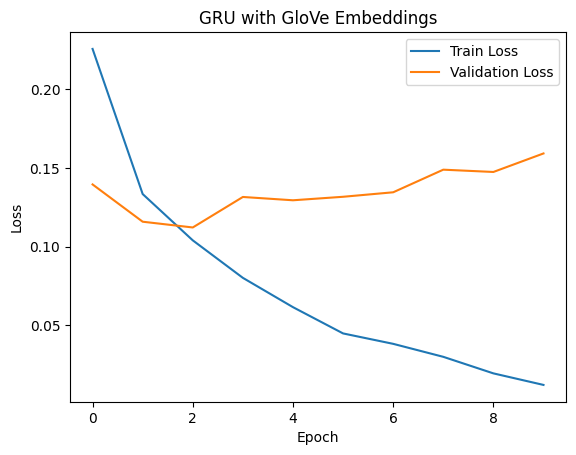

In [19]:
# Model 4 - GRU with GloVe embeddings
model_gru_glove = GRUTagger()
train_losses_gru_glove, val_losses_gru_glove = train_model(model_gru_glove, train_glove_loader, val_glove_loader, num_epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu', model_name="gru_glove")

# Plot loss curves
plt.figure()
plt.plot(train_losses_gru_glove, label='Train Loss')
plt.plot(val_losses_gru_glove, label='Validation Loss')
plt.title('GRU with GloVe Embeddings')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('gru_glove_loss.png')
plt.show()

### Evaluating Models

In [20]:
help(evaluate)

Help on function evaluate in module conlleval.conlleval:

evaluate(lines, delimiter=None, boundary='-X-', otag='O')
    Python equivalent for the `conlleval.pl` Perl script, which was
    used for measuring slot filling performance in the CoNLL-2000 shared task.
    
    Arguments:
        lines (iterator-like object): an iterator-like object that returns
            one line of a `conlleval`-style prediction-target text file
            at a time.
        delimiter (str): the delimiting character used to split tokens in
            a line. (default: default python `str.split` behavior)
        boundary (str): the boundary string that is used to indicate an end of
            a sentence (default: -X-)
        otag (str): the tag for items that do not belong any slots.
            (default: O)
    
    Returns:
        a dictionary object that contains all information that used to be
        returned by the old `conlleval.pl` perl script.



In [ ]:
# RNN with FastText embeddings
model_rnn_fastText = RNNTagger()
model_rnn_fastText.load_state_dict(torch.load("rnn_fastText.pt"))
f1_train_rnn_fastText, f1_val_rnn_fastText = get_f1_scores(model_rnn_fastText, train_fastText_loader), get_f1_scores(model_rnn_fastText, val_fastText_loader)
f1_train_chunk_level, f1_train_tag_level = f1_train_rnn_fastText
f1_val_chunk_level, f1_val_tag_level = f1_val_rnn_fastText
print(f"RNN with FastText embeddings:")
print(f"Train: Chunk-level F1: {f1_train_chunk_level} - Tag-level F1: {f1_train_tag_level}")
print(f"Val: Chunk-level F1: {f1_val_chunk_level} - Tag-level F1: {f1_val_tag_level}")

# RNN with GloVe embeddings
model_rnn_glove = RNNTagger()
model_rnn_glove.load_state_dict(torch.load("rnn_glove.pt"))
f1_train_rnn_glove, f1_val_rnn_glove = get_f1_scores(model_rnn_glove, train_glove_loader), get_f1_scores(model_rnn_glove, val_glove_loader)
f1_train_chunk_level, f1_train_tag_level = f1_train_rnn_glove
f1_val_chunk_level, f1_val_tag_level = f1_val_rnn_glove
print(f"RNN with GloVe embeddings:")
print(f"Train: Chunk-level F1: {f1_train_chunk_level} - Tag-level F1: {f1_train_tag_level}")
print(f"Val: Chunk-level F1: {f1_val_chunk_level} - Tag-level F1: {f1_val_tag_level}")

# GRU with FastText embeddings
model_gru_fastText = GRUTagger()
model_gru_fastText.load_state_dict(torch.load("gru_fastText.pt"))
f1_train_gru_fastText, f1_val_gru_fastText = get_f1_scores(model_gru_fastText, train_fastText_loader), get_f1_scores(model_gru_fastText, val_fastText_loader)
f1_train_chunk_level, f1_train_tag_level = f1_train_gru_fastText
f1_val_chunk_level, f1_val_tag_level = f1_val_gru_fastText
print(f"GRU with FastText embeddings:")
print(f"Train: Chunk-level F1: {f1_train_chunk_level} - Tag-level F1: {f1_train_tag_level}")
print(f"Val: Chunk-level F1: {f1_val_chunk_level} - Tag-level F1: {f1_val_tag_level}")

# GRU with GloVe embeddings
model_gru_glove = GRUTagger()
model_gru_glove.load_state_dict(torch.load("gru_glove.pt"))
f1_train_gru_glove, f1_val_gru_glove = get_f1_scores(model_gru_glove, train_glove_loader), get_f1_scores(model_gru_glove, val_glove_loader)
f1_train_chunk_level, f1_train_tag_level = f1_train_gru_glove
f1_val_chunk_level, f1_val_tag_level = f1_val_gru_glove
print(f"GRU with GloVe embeddings:")
print(f"Train: Chunk-level F1: {f1_train_chunk_level} - Tag-level F1: {f1_train_tag_level}")
print(f"Val: Chunk-level F1: {f1_val_chunk_level} - Tag-level F1: {f1_val_tag_level}")

RNN with FastText embeddings:
Train: Chunk-level F1: 0.7289514866979656 - Tag-level F1: 0.949504829441252
Val: Chunk-level F1: 0.7239263803680982 - Tag-level F1: 0.9521475256769374
RNN with GloVe embeddings:
Train: Chunk-level F1: 0.8761122518822725 - Tag-level F1: 0.9821494070179728
Val: Chunk-level F1: 0.7424657534246576 - Tag-level F1: 0.9586834733893558
GRU with FastText embeddings:
Train: Chunk-level F1: 0.8626855600539811 - Tag-level F1: 0.9786343073725394
Val: Chunk-level F1: 0.7549148099606815 - Tag-level F1: 0.957983193277311
GRU with GloVe embeddings:
Train: Chunk-level F1: 0.9676216307848788 - Tag-level F1: 0.9949260300770265
Val: Chunk-level F1: 0.7796610169491527 - Tag-level F1: 0.9619514472455649


Best performing model is GRU with GloVe

In [ ]:
def get_inference(file_name):
    with open(file_name) as f:
        data = json.load(f)
    test_data = preprocess_data(data)
    vec = glove_vec
    model = GRUTagger()
    model.load_state_dict(torch.load("gru_glove.pt", map_location=torch.device('cpu')))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    test_dataset = TextDataset(test_data, vec)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=embedding_colate_fn)

    model.eval()
    
    f1_test_chunk, f1_test_tag = get_f1_scores(model, test_loader, device)

    return f1_test_chunk, f1_test_tag

In [ ]:
f1_test_chunk, f1_test_tag = get_inference("val.json")
print(f"Test: Chunk-level F1: {f1_test_chunk} - Tag-level F1: {f1_test_tag}")

Test: Chunk-level F1: 0.7796610169491527 - Tag-level F1: 0.9619514472455649
